# in this notebook results of same time series are shown together
1. comparing the evaluation metrics
2. comparing the prediction itself

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## dataset info:

.321  train series
.2247 test series

for the last part we have 24(prediction_length) * 2247 = 53,928

## imports

In [2]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from gluonts.model.forecast import SampleForecast

## global variable

In [5]:
num_samples = 100

In [26]:
data_address = r'D:\ntnu\summer internship\code stuff\results' # this is for 100 resutls

### plot functions

In [7]:
# function to plot the sample forcast of one experiment as well as target value for a specific area
def plot_forscast(sample_forcast_list_val,
                  exp_n_val,
                  sample_n_val,
                  forcast_list_val=None):
    # make the sample object to use gluonts library
    sample_np = sample_forcast_list_val[exp_n_val].iloc[:, sample_n_val : sample_n_val + 24].to_numpy()
    tms = pd.Timestamp(1).now()
    sample_obj = SampleForecast(
            samples=sample_np,
            start_date=tms,
#             )h
            freq='H',
#             item_id=self.item_id,
#             info=self.info,
            )
    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize=(20,10))
    prediction_intervals = (50, 99.99)
    legend = ["median prediction", "mean"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    ax2 = sample_obj.plot(prediction_intervals=prediction_intervals, color='g', show_mean=True)
    # if forcast_list_val is passed, the target will be plotted as well
    if forcast_list_val is not None:
        # extra part
        target_forcast_series = get_forcast_target(forcast_list)
        target_slice = target_forcast_series.iloc[sample_n_val : sample_n_val + 24]
        target_date_range = pd.date_range(tms, periods=len(target_slice), freq='H')
        target_slice.index = target_date_range
        ax2 = target_slice.plot()
    plt.legend(legend, loc="upper left")
    sample_forcast_list_val[exp_n_val].iloc[:, sample_n_val : sample_n_val + 24].T.plot(legend=False, ax=ax1)
    return fig

In [8]:
# plots a same area for all the samples
def plot_forscast_same(sample_forcast_list_val,
                       sample_n_val,
                       lim=10):
    color_list = ['g','b','r','y','cyan', 'orange', 'brown', 'purple', 'pink', 'gray']
    for idx, sample_el in enumerate(sample_forcast_list_val):
        # check if we have more than 10 diagrams
        if idx > lim:
            break
        sample_np = sample_el.iloc[:, sample_n_val : sample_n_val + 24].to_numpy()
        tms = pd.Timestamp(1).now()
        sample_obj = SampleForecast(
                samples=sample_np,
                start_date=tms,
                freq='H',
                )
        prediction_intervals = (25, 50)
        legend = ["median prediction", "mean"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        sample_obj.plot(prediction_intervals=prediction_intervals, color=color_list[idx], show_mean=True)

    plt.legend(legend, loc="upper left")
    plt.show()

In [9]:
# this is the plot function we call which uses plot_forcast to plot multiple plots and save the results
def save_plot_exp(exp_lim, sample_n):
    for idx in range(exp_lim):
        a=plot_forscast(sample_forcast_list, idx, sample_n)
        a.savefig(f'plots/result_sample{sample_n}_exp{idx}')

In [10]:
def show_pred_plots(sorted_forcast_list, point, lim=100):
    for i in range(lim):
        plt.plot(sorted_forcast_list[i].iloc[point-50:point+50]['mean'].to_numpy())

    plt.plot(sorted_forcast_list[i].iloc[point-50:point+50]['target'].to_numpy())

### Dataloading functions

read each metrics as a dataframe first

In [11]:
def read_csv_result(result_type, address, n_files=None):
    rootdir = address
    os.path.isdir(rootdir)

    df_list = []
    filenames = []

    for subdir, _, files in tqdm(os.walk(rootdir)):
        filenames += [os.path.join(subdir, file) for file in files if file == result_type]

    if n_files is not None:
        filenames = filenames[:n_files]
        
    for filename in tqdm(filenames, ascii=True, ncols=50):
        df = pd.read_csv(filename)
        df_list.append(df)
        
    return df_list

### metrics function

In [12]:
# it returns a dataframe of metrics of all test datas for all the experiements

def get_metric_df(metric_list_val, metric_name = 'MAPE'): 
    metric_df_list = []
    # number of testseries
    test_set_len = metric_list_val[0].shape[0]
    
    # number of experiments we did
    exp_len = 0
    # we need to set a name for it
    for metrics_experiment in metric_list_val:
        exp_len += 1
        current_mse_series = metrics_experiment[metric_name]
        current_mse_series.name = f'rep_{exp_len}'
        metric_df_list.append(current_mse_series)
    metric_dataframe = pd.concat(metric_df_list, axis=1).T
    return metric_dataframe

In [13]:
# plots limited number of elements of list of dataframes
def plot_df_list(sample_forcast_list_val, no_plot = 5):
    for i, forcast_el in enumerate(sample_forcast_list_val):
        if i > no_plot:
            break
        forcast_el[0].plot()

### forcast function

In [14]:
# returns list of all dfs with only samples column
def get_forcast_samples(forcast_list_val):
    num_exp = len(forcast_list_val)
    
    # get just samples columns
    sample_forcast_list_val = []
    for forcast_el_val in forcast_list_val:
        sample_forcast_list_val.append(forcast_el_val.loc[:, 'sample0':f'sample{num_samples-1}'].T)
    return sample_forcast_list_val

In [15]:
# returns list of all dfs with only samples column
def get_forcast_distrib(forcast_list_val):
    num_exp = len(forcast_list_val)
    
    # get just samples columns
    distrib_forcast_list = []
    for forcast_el_val in forcast_list_val:
        # first get the samples
        sample_forcast_elm = forcast_el_val.loc[:, 'sample0':f'sample{num_samples-1}'].T
            
        mean  = sample_forcast_elm.mean()
        sigma = sample_forcast_elm.std(ddof=1)
        forcast_distrib_dict = {'mean' : mean, 'sigma' : sigma} 
        forcast_distrib_df = pd.DataFrame(forcast_distrib_dict).T
        forcast_distrib_df
        distrib_forcast_list.append(forcast_distrib_df)
    return distrib_forcast_list

In [16]:
# returns list of all dfs with only samples column
def get_forcast_distrib_sample(sample_forcast_list_val):
    num_exp = len(sample_forcast_list_val)
    
    # get just samples columns
    distrib_forcast_list = []
    for sample_forcast_elm in sample_forcast_list_val:
        mean  = sample_forcast_elm.mean()
        sigma = sample_forcast_elm.std(ddof=1)
        forcast_distrib_dict = {'mean' : mean, 'sigma' : sigma} 
        forcast_distrib_df = pd.DataFrame(forcast_distrib_dict).T
        forcast_distrib_df
        distrib_forcast_list.append(forcast_distrib_df)
    return distrib_forcast_list

In [17]:
# outputs numpy 3d array of shape [num_exp, num_samples, num_test * prediction_length]
def get_np_forcast(sample_forcast_list_val):
    num_exp = len(sample_forcast_list_val)
    forcast_np = np.zeros((num_exp,*sample_forcast_list_val[0].shape))
    for idx in range(num_exp):
        forcast_np[idx] = sample_forcast_list_val[idx].to_numpy()
    return forcast_np

In [18]:
# calculate the std of 3d np array, shape of output = [num_samples, num_test * prediction_length]
def get_std_np(forcast_np, sample_forcast_list_val):
    forcast_std_np = np.zeros(sample_forcast_list_val[0].shape)
    for idx in range(forcast_np.shape[-1]):
        forcast_std_np[:,idx] = forcast_np[:,:,idx].std(axis = 0)
    return forcast_std_np

In [19]:
# returns the target serie
def get_forcast_target(forcast_list):
    return forcast_list[0].loc[:, 'target'].T

In [20]:
def convert_df2np_mean_std(sorted_forcast_list):
    num_exp = len(sorted_forcast_list)
    sorted_forcast_list[0].shape
    sorted_forcast_np = np.zeros((num_exp, sorted_forcast_list[0].shape[0], 2))
    for idx in range(num_exp):
        sorted_forcast_np[idx] = sorted_forcast_list[idx].loc[:, 'mean':'std'].to_numpy()
    return sorted_forcast_np

In [21]:
def get_avg_mean_sorted_train_series(forcast_list_el):
    forcast_list_el['train_series_number'] = forcast_list_el['series_number']%321
    forcast_list_el.set_index('train_series_number', inplace=True)
    forcast_list_el.sort_values(by=['train_series_number', 'timestamp'], inplace=True)
    forcast_list_el['mean'] = forcast_list_el.loc[:, 'sample0':f'sample{num_samples-1}'].mean(axis=1)
    forcast_list_el['std'] = forcast_list_el.loc[:, 'sample0':f'sample{num_samples-1}'].std(axis=1)
    return forcast_list_el

In [22]:
def get_sorted_csv(forcast_list):
    for forcast_list_element in forcast_list:
        forcast_list_element = get_avg_mean_sorted_train_series(forcast_list_element)
    return forcast_list

### quantile filter functions

In [23]:
# get the interval of 0.25 to 0.75 quantile of sample forcast
def make_50ps_intervals(sample_forcast_list_element_val):
    my_df1 = sample_forcast_list_element_val
    q11 = my_df1.quantile(0.25)
    q21 = my_df1.quantile(0.75)
    mask1 = (my_df1 < q21) & (q11 < my_df1)
    return my_df1[mask1]

In [24]:
# make a list of 50% intervals
def make_50ps_interval_list(sample_forcast_list_val, list_lim=None):
    quantile_sample_list = []
    
    if list_lim is not None:
        sample_forcast_list_val = sample_forcast_list_val[:list_lim]
        
    for sample_forcast_list_element in sample_forcast_list_val:
        quantile_sample_list.append(make_50ps_intervals(sample_forcast_list_element))
    return quantile_sample_list

# forcast

In [27]:
# read the forcast file
forcast_list = read_csv_result('forcasts.csv', data_address)

101it [00:00, 3616.67it/s]
100%|###########| 100/100 [02:47<00:00,  1.68s/it]


In [43]:
target_forcast_series = get_forcast_target(forcast_list)

In [29]:
len(forcast_list)

100

In [30]:
sorted_forcast_list = get_sorted_csv(forcast_list)

In [31]:
sorted_forcast_list[1]

,fold_num,series_number,timestamp,target,sample0,sample1,sample2,sample3,sample4,sample5,...,sample192,sample193,sample194,sample195,sample196,sample197,sample198,sample199,mean,std
train_series_number,,,,,,,,,,,,,,,,,,,,,
0,1,0,2014-05-26 20:00:00,9.0,15.892927,18.794500,18.420332,17.061580,16.810068,14.809458,...,15.053331,20.764126,15.472470,18.485811,13.345155,15.998700,17.309755,18.525433,16.152926,6.072224
0,1,0,2014-05-26 21:00:00,10.0,11.395522,27.619148,22.450666,19.784697,25.118587,22.732674,...,31.275389,18.833230,20.418943,28.459894,20.115650,12.570258,17.264938,35.590595,24.933873,15.715126
0,1,0,2014-05-26 22:00:00,22.0,15.177665,23.064526,21.949125,20.139013,27.152613,26.541948,...,23.767262,23.887754,20.911710,23.528688,23.562187,17.816390,32.024067,20.031101,23.615871,5.219006
0,1,0,2014-05-26 23:00:00,20.0,26.110151,23.727999,24.061516,25.099686,27.715292,27.110880,...,26.369158,26.690603,37.453197,23.301653,23.394472,31.798910,24.638493,25.139648,25.168595,2.844431
0,1,0,2014-05-27 00:00:00,13.0,18.620432,24.962437,23.973990,24.638863,24.656963,23.977100,...,35.998410,23.383220,24.781548,25.899340,26.582882,25.278630,29.250034,25.048786,25.140975,2.834288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,1,2246,2014-06-02 15:00:00,4209.0,3556.128200,3495.187500,3573.766800,3583.237000,3648.945600,3070.738000,...,3549.334500,3433.842500,3605.771500,3279.942600,3466.019800,3350.491000,3399.727800,3461.791300,3458.142844,206.789298
320,1,2246,2014-06-02 16:00:00,4120.0,3568.239500,3379.677500,3231.048300,3156.940700,3719.435800,3752.326200,...,3607.235800,3358.222000,3766.255900,3362.689700,3818.466300,3380.908700,3474.055200,3640.999800,3495.386250,408.821272
320,1,2246,2014-06-02 17:00:00,3951.0,3807.390900,3334.639200,3423.653800,3244.171100,3672.534400,3492.841800,...,4042.393600,3210.830600,3346.973900,3557.066400,3782.202400,3503.328400,3578.726800,3528.385700,3494.222665,264.781334


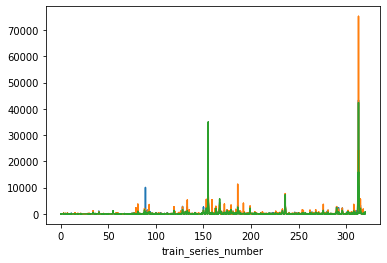

In [32]:
sorted_forcast_list[0].loc[:, 'std'].plot()
sorted_forcast_list[1].loc[:, 'std'].plot()
sorted_forcast_list[2].loc[:, 'std'].plot()

### now we need to get the 3d numpy array of std and avg

In [33]:
sorted_forcast_np = convert_df2np_mean_std(sorted_forcast_list)
sorted_forcast_np[1]

array([[  16.15292598,    6.07222439],
       [  24.93387295,   15.71512571],
       [  23.61587132,    5.21900573],
       ...,
       [3494.222665  ,  264.78133429],
       [3387.870682  ,  272.51301387],
       [3154.7027841 ,  444.59983165]])

In [34]:
std_sorted = sorted_forcast_np.std(axis=0)
std_sorted.shape

(53928, 2)

In [35]:
pd.DataFrame(std_sorted)

,0,1
0,1.456205,3.096828
1,2.242264,9.025018
2,2.178647,2.446077
3,2.065511,2.022185
4,2.282157,1.130348
...,...,...
53923,210.244221,66.198003
53924,214.669200,89.578699
53925,219.079365,59.015864
53926,216.648398,59.951770


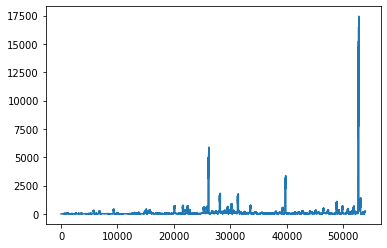

In [36]:
pd.DataFrame(std_sorted)[0].plot()

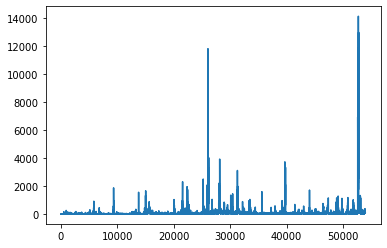

In [37]:
pd.DataFrame(std_sorted)[1].plot()

In [38]:
# pd.DataFrame(std_sorted)[1].idxmax(2)
pd.DataFrame(std_sorted)[1].nlargest(10)

52701    14132.793073
52750    12982.734370
52730    11910.958566
26052    11812.823917
52728    11659.567396
52703    10470.220389
52654     9463.669679
52680     9018.348051
52629     8711.361373
52636     8681.130545
Name: 1, dtype: float64

In [39]:
pd.DataFrame(std_sorted).iloc[52704]

0    11980.020704
1     3284.296754
Name: 52704, dtype: float64

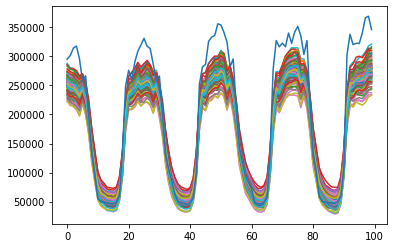

In [40]:
show_pred_plots(sorted_forcast_list, 52701)

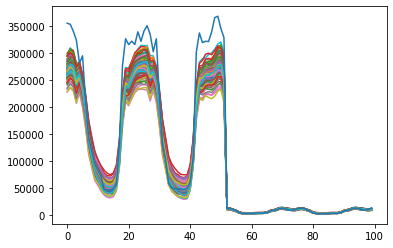

In [41]:
show_pred_plots(sorted_forcast_list, 52750)

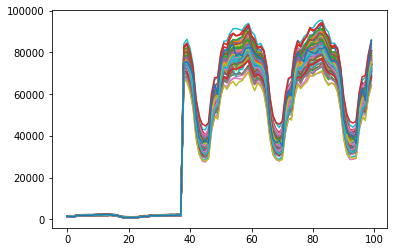

In [42]:
show_pred_plots(sorted_forcast_list, 26052)